# Back propagation своими руками

В этом задании мы построим нейросеть на numpy и обучим ее с помощью градиентного спуска.

В numpy нет автоматического дифференцирования, поэтому нам придется самостоятельно считать градиент
и "тащить" его через всю сеть (с конца в начало).

Это задание будет полезно для более глубокого понимания работы back propagation "под капотом".

Будем делать задание в несколько этапов:
1. Подготовим данные.
2. Построим сеть "Linear + Tanh + Linear" для регрессии, используя pytorch, обучим ее.
С ней будем дальше сравниваться.
3. Напишем линейный слой на numpy, научим его считать свой градиент.
4. Напишем Tanh слой, научим его считать свой градиент.
5. Напишем алгоритм back propagation, который будет распространять градиент с конца в начало.

Учить все это будем на MSE обычным градиентным спуском (без батчей и с константным learning rate).
Почему Tanh - для него более показательная производная.
MSE - простой градиент, будет проще реализовать.
Градиентный спуск сделаем тоже максимально простым, т.к. наш фокус в этом задании на слои сети, а не алгоритмы оптимизации.

## Подготовка данных

Возьмем готовые данные из урока 2.

In [9]:
import pandas as pd

# В train.csv и test.csv лежат данные из урока 2 после препроцессинга
df_train = pd.read_csv("train.csv", index_col=0)
df_train.drop(columns=['sex', 'region', 'smoker'], axis=1, inplace=True)
df_test = pd.read_csv("test.csv", index_col=0)
df_test.drop(columns=['sex', 'region', 'smoker'], axis=1, inplace=True)
x_train = df_train.copy()
y_train = x_train.pop("charges")
x_test = df_test.copy()
y_test = x_test.pop("charges")

In [10]:
x_train.head(5)

,age,bmi,children,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest,smoker_no,smoker_yes
0,-1.443656,-0.440973,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-1.514986,0.537508,1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,-0.801683,0.409155,3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.445032,-1.306937,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-0.516362,-0.277615,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [11]:
y_train.head(5)

0    0.341230
1   -0.963381
2   -0.728963
3    0.780095
4   -0.779102
Name: charges, dtype: float64

## Строим сеть на PyTorch

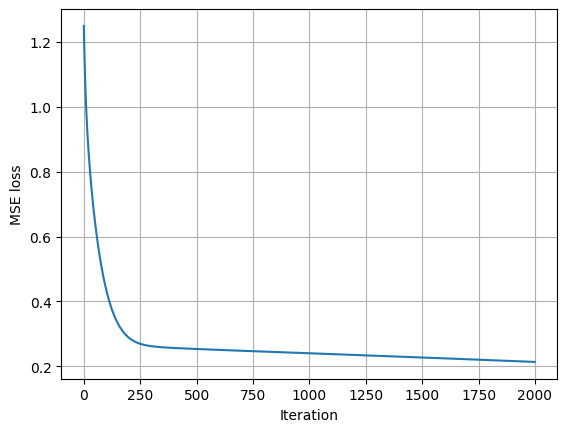

100%|██████████| 2000/2000 [00:02<00:00, 757.50it/s] 

Final losses: [0.2133040726184845, 0.21327617764472961, 0.21324829757213593, 0.21322041749954224, 0.21319252252578735]


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import tqdm
from IPython.display import clear_output
from torch.optim import SGD

lr, num_iter = 1e-2, 2_000
torch.random.manual_seed(0)
torch_model = nn.Sequential(
    nn.Linear(len(x_train.columns), 32, bias=False),
    nn.Tanh(),
    nn.Linear(32, 1, bias=False),
)


# train_loop взят из урока 2
def train_loop(model: nn.Module) -> list[float]:
    t_x_train = torch.from_numpy(x_train.values.astype(np.float32))
    t_y_train = torch.from_numpy(y_train.values.astype(np.float32))
    torch.random.manual_seed(0)
    losses = []
    optim = SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for i in tqdm.trange(num_iter):
        optim.zero_grad()
        out = model(t_x_train)[:, 0]
        loss = criterion(out, t_y_train)
        loss.backward()
        losses.append(loss.item())
        optim.step()

        # интерактивно рисуем графики каждые 100 итераций
        if (i + 1) % 100 == 0:
            # Чистим прошлый график
            clear_output(wait=True)
            # рисуем новый
            plt.plot(losses)
            plt.grid()
            plt.xlabel("Iteration")
            plt.ylabel("MSE loss")
            plt.show()

    return losses


print(f"Final losses: {train_loop(torch_model)[-5:]}")

Теперь перейдем к самой интересной части.

## Линейный слой на numpy

Мы начнем с простого: forward pass линейного слоя.
Для простоты исключим bias из слоя.

Линейный слой принимает на вход метрицу $X$ размера $(N, K)$ и при прямом прохождении (forward pass) преобразует $X$ следующим образом:

$$
y = XW
$$

где $W$ - матрица размером $(K, d)$, $y$ - выход слоя размерности $(N, d)$.

In [19]:
from numpy.testing import assert_allclose

"""Допишите:
- инициализацию весов
- метод forward
для заготовки ниже.
"""


class MyLinearLayer:
    def __init__(self, dim_in: int, dim_out: int):
        self.dim_in = dim_in
        self.dim_out = dim_out

        # Напишите сюда правильную размерность
        self.W = np.random.randn(self.dim_in, self.dim_out)

    def get_params(self):
        # Для удобства сделаем функцию, которая будет возвращать все параметры слоя
        # В случае линейного это будет только вес
        return (self.W,)

    def forward(self, X: np.ndarray) -> np.ndarray:
        y = X @ self.W
        return y


layer = MyLinearLayer(dim_in=3, dim_out=2)
layer.W = np.array([[1, 2], [3, 4], [5, 6]])
assert_allclose(
    layer.forward(np.array([[1, 2, 3], [4, 5, 6]])),
    np.array([[22, 28], [49, 64]]),
)

В лекции мы обсуждали back propagation. В частности,

- градиент считается с конца в начала;
- градиент сложной функции разбивается на произведение;

Разберем в деталях.
Возьмем задачу регрессии с данными:
$$
X = \begin{bmatrix}
  1 & 2 \\
  4 & 5
\end{bmatrix}
$$
и таргетом $$y = \begin{bmatrix} 5 \\ 7 \end{bmatrix} $$

Допустим, мы решаем задачу одним линейным слоем без смещения и с весами
$$W = \begin{bmatrix} 4 \\ 5 \end{bmatrix} $$

Получим: $\hat{y} = X W = \begin{bmatrix}1 & 2 \\ 4 & 5 \end{bmatrix} \begin{bmatrix} 4 \\ 5 \end{bmatrix} = \begin{bmatrix} 1 \cdot 4 + 2 \cdot 5 \\ 4 \cdot 4 + 5 \cdot 5 \end{bmatrix} = \begin{bmatrix} 14 \\ 41 \end{bmatrix}$.

$$
L = (14 - 5)^2 + (41 - 7)^2 = 1237
$$

Теперь к градиентам.
$$
dL (\hat{y}(W)) = d_W (\hat{y}) \cdot dL(\hat{y}) |_{\hat{y} = X W}
$$
Везде в формуле $\hat{y} = XW$.

Переходим к подсчетам: $L = \sum_{i=1}^N (\hat{y}_i - y_i)^2$, тогда
$$
\cfrac{\partial L}{\partial \hat{y}} = 2 (\hat{y} - y)
$$
Заметьте, этот градиент можно уже подсчитать, все числа нам даны.

**Задание 2**: какой размерности должен быть вектор этого градиента? Отправьте в ЛМС одно целое число - размерность вектора.

In [20]:
2

2

**Задание 3**: подставьте числа, подсчитайте вектор градиента и отправьте в ЛМС его компоненты, разделенные запятой (без разницы, с пробелом или без). Например, если вектор [4, 9, 2], то в ЛМС можно отправить "4, 9, 2" или же "4,9,2".

In [ ]:
18, 68

Зная вектор $\cfrac{\partial L}{\partial \hat{y}}$, можем получить градиент по весам - это уже делали в лекции.
В лекции получилось:
$$
\cfrac{\partial L}{\partial W} = X^T \cdot \cfrac{\partial L}{\partial \hat{y}}
$$
Заметьте, что множители поменялись местами ($\frac{\partial L}{\partial \hat{y}}$ уехал вправо).

**Задание 4**: подсчитайте этот градиент и отправьте в ЛМС (формат тот же, что в задании 3).

In [ ]:
290, 376

Дополнительно нужно подсчитать градиент по $X$:
$$
\cfrac{\partial L}{\partial X} = \cfrac{\partial L}{\partial \hat{y}} \cdot W^T
$$

Рассуждения те же, что в лекции (должно быть что-то в духе "производная умножить на $W$"), подгоняем по размерности - и получаем финальную формулу.

Окей, но как теперь обобщить наш результат?
Давайте добавим в каждый слой функцию `backward`, которая на вход будет принимать:
- градиент по выходу (в нашем случае это $\frac{\partial L}{\partial \hat{y}}$) - это чтобы уметь обрабатывать случай, когда множители меняются местами;
- вход слоя - т.к. мы используем $X^T$;
- выход слоя - иногда удобнее через него формулу переписывать;

и на выходе функция будет выдавать градиент по входу.
Т.е. каждый слой научим преобразовывать:
$$
\cfrac{\partial L}{\partial (out)} \xrightarrow[]{\text{backward}} \cfrac{\partial L}{\partial (in)}
$$

Тогда алгоритм back propagation для N слоев будет следующим:
1. Подсчитать градиент MSE: $\cfrac{\partial L}{\partial y_N}$
2. Подсчитать $\cfrac{\partial L}{\partial W_N}$, зная производную из предыдущего пункта и входы сети.
3. Вызвать `backward` и получить $\cfrac{\partial L}{\partial y_{N-1}}$ из $\cfrac{\partial L}{\partial y_N}$.
4. Вернуться в п.2 для получения $\cfrac{\partial L}{\partial W_{N-1}}$ (веса предыдущего слоя);

In [30]:
np.array([[18, 72]]).T

array([[18],
       [72]])

In [45]:
"""Добавьте в класс MyLinearLayerV2 функцию backward по описанию из ноутбука.
Залейте в ЛМС код MyLinearLayerV2.
"""


class MyLinearLayerV2(MyLinearLayer):
    def backward(
        self, output_grad: np.ndarray, layer_input: np.ndarray, layer_output: np.ndarray
    ):
        grad_by_W = np.matmul(layer_input.T, output_grad)
        grad_by_inputs = np.matmul(output_grad, self.W.T)
        # grad_by_inputs - это градиент по входу
        # grad_by_W - это градиент по W (который X^T * ...)
        return grad_by_inputs, [grad_by_W]


# Прогоним над примером из текста
layer = MyLinearLayerV2(dim_in=2, dim_out=1)
layer.W = np.array([[4, 5]]).T
x = np.array([[1, 2], [4, 5]])
out = layer.forward(x)
grad_mse = np.array([[18, 72]]).T
grad_by_input, [grad_by_W] = layer.backward(grad_mse, x, None)

assert_allclose(grad_by_W, np.array([[306], [396]]))
# не используем в случае 1 слоя, но должны уметь считать
assert_allclose(grad_by_input, np.array([[72, 90], [288, 360]]))

print("Выход слоя:\n", out)
print("Градиент MSE по выходу:\n", grad_mse)
print("Градиент по W:\n", grad_by_W)
print("Градиент по входу:\n", grad_by_input)

Выход слоя:
 [[14]
 [41]]
Градиент MSE по выходу:
 [[18]
 [72]]
Градиент по W:
 [[306]
 [396]]
Градиент по входу:
 [[ 72  90]
 [288 360]]


## Нелинейный слой
В нашей сети будет еще нелинейность.
Разберемся с ней.

Как мы увидели на линейном слое, нам нужно считать:
- градиент по входу
- градиент по всем параметрам слоя;

В нелинейности нет параметров, поэтому нужна только одна формула: градиента по входу.

Tanh применяет преобразование $y = \tanh(x)$ поэлементно.
В интернете находим, что $$(\tanh x)' = \cfrac{1}{\cosh^2 x} = \cfrac{2}{e^x + e^{-x}}$$

Осталось собрать это с chain rule и не ошибиться с размерностями:
$$
d L (\tanh (x)) = d L (t)|_{t=\tanh(x)} \cdot d(\tanh x)
$$

Первый множитель говорит, как меняется $L$ при изменении $\tanh(x)$ (меняем не $x$, а именно $\tanh(x)$).
Второе - как меняется $\tanh(x)$ при изменении $x$.

Тут проще думать поэлементно: было число $x_{ij}$, после слоя стало $\tanh(x_{ij})$ - тоже число.
Для чисел есть формула производной сложной функции:
$\cfrac{d(L(\tanh(x)))}{dx} = \underbrace{\cfrac{d(L(t)) |_{t=\tanh(x)}}{dt}}_\text{градиент по выходу} \cdot \cfrac{d(\tanh x)}{dx}$

Т.е. градиент по входу - это градиент по выходу, умноженный покоординатно на $(\tanh x_{ij})'$

In [ ]:
"""Реализуйте класс MyTanh в соответствии с комментариями ноутбука."""


class MyTanh:
    def forward(self, x: np.ndarray):
        y = np.tanh(x)
        return y
    
    def get_params(self):
        return ()

    def backward(
        self, output_grad: np.ndarray, layer_input: np.ndarray, layer_output: np.ndarray
    ):
        grad_tanh  = 2 / (np.e**layer_input + np.e**(-layer_input))
        grad_by_input = output_grad * grad_tanh 
        return grad_by_input, []


tanh_layer = MyTanh()
# ТЕСТЫ
# Простой пример: будем решать уравнение tanh(x) = tanh(1)
# Очевидно, что x = 1 является решением, но представим, что мы этого не знаем
# Будем делать град. спуск из точки 5 - ожидаем придти в точку x = 1
expected = np.tanh([1.0])
init_ = np.array([5.0])
for _ in range(1_000):
    grad, _ = tanh_layer.backward(
        2 * (tanh_layer.forward(init_) - expected),  # loss от mse
        init_,  # вход слоя
        None,  # не используется
    )
    init_ = init_ - 0.2 * grad
assert_allclose(init_, 1, rtol=1e-3)

Итак, у нас есть линейный слой и tanh слой, оба умеют считать градиенты.
Соберем теперь back propagation из них.

In [80]:
np.random.seed(0)
my_model = [
    MyLinearLayerV2(len(x_train.columns), 32),
    MyTanh(),
    MyLinearLayerV2(32, 1),
]


def gd_step(model: list, x: np.ndarray, y: np.ndarray):
    inputs, outputs = [], []
    N = x.shape[0]
    # Прогоним все слои, сохраним все промежуточные результаты
    for one_layer in model:
        inputs.append(x if not outputs else outputs[-1])
        result = one_layer.forward(inputs[-1])
        outputs.append(result)
    # Последний выход уже предсказывает целевую переменную
    y_pred = outputs[-1]
    assert y_pred.shape == (N, 1)
    assert y.shape == (N,)
    y_pred = y_pred[:, 0]
    # Заметьте, для back propagation не нужно знать само значение MSE
    grad_mse = 2 / N * (y_pred - y)
    # Чтобы не было проблем с размерностью, сделаем не (N, ), а (N, 1)
    grad_current = grad_mse[:, None]
    # Теперь все готово к back propagation - идем с конца в начало
    for one_layer, one_input, one_output in zip(
        model[::-1], inputs[::-1], outputs[::-1]
    ):
        grad_by_input, grad_params = one_layer.backward(grad_current, one_input, one_output)

        # Если слой имеет параметры, обновляем их
        params = one_layer.get_params()
        if params:  
            one_layer.W -= lr * grad_params[0]  # Обновляем только если есть веса
        
        grad_current = grad_by_input  # Передаём градиент дальше

        # Напишите код, который будет:
        # - получать градиенты по параметрам
        # - обновлять параметры (шаг градиентного спуска, используйте lr)
        # - обновляеть градиент предыдущего слоя (переменная grad_current)

        # В функции backward() первым всегда возвращается градиент по входу.
        # Вторым - список градиентов по параметрам,
        # в том же порядке, в котором идут параметры в get_params()

        ...

    # Подсчитаем MSE, чтобы его залоггировать
    mse_loss = 1 / N * ((y_pred - y) ** 2).sum()
    return mse_loss


gd_step(my_model, x_train.values.astype(np.float32), y_train.values.astype(np.float32))

12.65840079034814

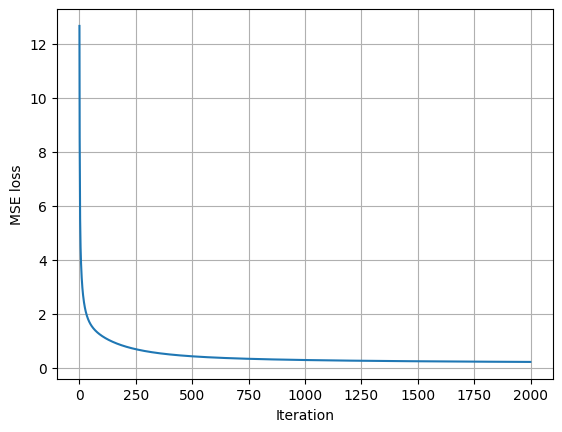

100%|██████████| 2000/2000 [00:03<00:00, 577.14it/s]

Final losses: [0.21267343413952633, 0.21263567660068716, 0.21259795246844435, 0.2125602616958477, 0.21252260423604175]


: 

In [ ]:
np.random.seed(0)
my_model = [
    MyLinearLayerV2(len(x_train.columns), 32),
    MyTanh(),
    MyLinearLayerV2(32, 1),
]
losses = []
for i in tqdm.trange(num_iter):
    losses.append(
        gd_step(
            my_model,
            x_train.values.astype(np.float32),
            y_train.values.astype(np.float32),
        )
    )
    if (i + 1) % 100 == 0:
        clear_output(wait=True)
        plt.plot(losses)
        plt.grid()
        plt.xlabel("Iteration")
        plt.ylabel("MSE loss")
        plt.show()

print(f"Final losses: {losses[-5:]}")

Если у вас та же картинка, что была в начале ноутбука, то поздравляем - вы написали градиентный спуск своими руками.

А именно:
- вы написали линейный и tanh слои и back propagation для них;
- потренировали и увидели, что оно работает;
- вспомнили все формулы для линейного слоя;

Функция gd_step устроена таким образом, что вы можете свою сеть расширять до любого количества слоев. Поэкспериментируйте :)

Конечно же, в pytorch поудобнее вышло, чем в нашей реализации.
Дело в том, что pytorch делает много "магии":
- pytorch сам отслеживает все входы и выходы слоев (мы это явно делали в переменных `inputs` и `outputs`)
- прячет всю оптимизацию в класс `SGD`
- сам строит граф вычислений (в случае сложных сетей)